In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/home/pierre/git/semisupervised


In [4]:
import os
import torch
import yaml
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from itertools import product
from module.utils import compute_N_colours
from module.plot_script import ci
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 18})
# plt.rcParams['text.usetex'] = True
supported_labels = [
    "random",
    "local_search",
    "ei",
    "ei_ego_network_1",
    "ei_ego_network_1_old",
    "dfs",
    "bfs",
    "ei_ego_network_2",
    "ei_ego_network_2_no_ard",
]
# cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']))
d_color = {"ei_ego_network_1":"#1f77b4", "ei_ego_network_2":"#8c564b", "random":"#ff7f0e",
           "local_search":"#2ca02c", "dfs": "#d62728", "bfs": "#9467bd", "ei_ego_network_1_old":"#e377c2",
           "ei_ego_network_2_no_ard":"#7f7f7f", "ei_ego_network_matern":'#bcbd22'}
d_label = {"ei_ego_network_1":"BO_Poly", "ei_ego_network_1_old":"BO_SumInverse",
           "ei_ego_network_2":"BO_Diff_ARD", "ei_ego_network_2_no_ard":"BO_Diff", 
           "random":"Random", "local_search":"Local search", "dfs": "Dfs", "bfs": "Bfs",
           "ei_ego_network_matern":"BO_Matern"}

algo_to_label = {"probESCMAES": "Prob CMAES (ours)",
                 "probESXNES": "Prob XNES (ours)",
                 "probESSNES": "Prob SNES (ours)",
                 "ESCMAES": "CMAES",
                 "ESXNES": "XNES",
                 "ESSNES": "SNES",
                 "piqEI": r"$\pi$" + "BO",
                 "random": "random",
                 "qEI": "BO"}

In [5]:
def create_path_exp(save_dir, problem_name, problem_kwargs):
    if problem_name == "test_function":
       s = "_".join([problem_kwargs["function"], f'noise_std-{problem_kwargs["noise_std"]}', f'initial_bounds-{problem_kwargs["initial_bounds"]}'])
    # if problem_name == "test_function":
    #    s = "_".join([problem_kwargs["function"], f'noise_std-{problem_kwargs["noise_std"]}', f'dim-{problem_kwargs["dim"]}', f'initial_bounds-{problem_kwargs["initial_bounds"]}'])
    elif problem_name == "latent_space":
       s = "_".join([problem_kwargs["function"], f'noise_std-{problem_kwargs["noise_std"]}', f'initial_bounds-{problem_kwargs["initial_bounds"]}', f'label-{problem_kwargs["label"]}'])
    elif problem_name == "uci":
       s = "_".join([problem_kwargs["function"].replace(" ", "_"), f'noise_std-{problem_kwargs["noise_std"]}', f'initial_bounds-{problem_kwargs["initial_bounds"]}'])
    elif problem_name == "hyperparameter_opt":
       s = "_".join([problem_kwargs["function"], f'noise_std-{problem_kwargs["noise_std"]}', f'initial_bounds-{problem_kwargs["initial_bounds"]}', f'label-{problem_kwargs["label"]}'])
    else:
        raise NotImplementedError
    save_path = os.path.join(save_dir, s)
    return save_path

def alg_name(algorithm_name, alg_kwargs):
  if algorithm_name == "probES":  #["probES", "ES", "random", "qEI", "piqEI"]
    s = "_".join([f'type-{alg_kwargs[algorithm_name]["type"]}', f'policy-{alg_kwargs[algorithm_name]["policy"]}', f'gradient-{alg_kwargs[algorithm_name]["gradient"]}', f'aqc_typef-{alg_kwargs[algorithm_name]["aqc_type"]}', f'mahalanobis-{alg_kwargs[algorithm_name]["mahalanobis"]}', f'mean_prior-{alg_kwargs[algorithm_name]["mean_prior"]}', f'std_prior-{alg_kwargs[algorithm_name]["std_prior"]}', f'lr-{alg_kwargs[algorithm_name]["lr"]}', f'batch_size-{alg_kwargs["batch_size"]}', f'evaluation-{alg_kwargs["evaluation"]}'])
  elif algorithm_name == "ES":
    s = "_".join([f'type-{alg_kwargs[algorithm_name]["type"]}', f'mean_prior-{alg_kwargs[algorithm_name]["mean_prior"]}', f'std_prior-{alg_kwargs[algorithm_name]["std_prior"]}', f'batch_size-{alg_kwargs["batch_size"]}', f'evaluation-{alg_kwargs["evaluation"]}'])
  elif algorithm_name == "qEI":
    s = "_".join([f'batch_size-{alg_kwargs["batch_size"]}'])
  elif algorithm_name == "piqEI":
    s = "_".join([f'beta-{alg_kwargs[algorithm_name]["beta"]}', f'mean_prior-{alg_kwargs[algorithm_name]["mean_prior"]}', f'std_prior-{alg_kwargs[algorithm_name]["std_prior"]}', f'batch_size-{alg_kwargs["batch_size"]}']) 
  elif algorithm_name == "random":
    s = "_".join([f'mean_prior-{alg_kwargs[algorithm_name]["mean_prior"]}', f'std_prior-{alg_kwargs[algorithm_name]["std_prior"]}', f'batch_size-{alg_kwargs["batch_size"]}'])
  return s

def create_path_alg(save_path, algorithm_name, alg_kwargs):
    s = alg_name(algorithm_name, alg_kwargs)
    save_path = os.path.join(save_path, s)
    return save_path

In [6]:
def plot_figure_algo(alg_dir, ax, log_transform=False, regret=True, color=None, amin = -5, line_type=".", label_plot=True, ablation = None):
    data_path_seeds = [f for f in os.listdir(alg_dir) if ".pt" in f]
    data_over_seeds = []
    for _, df in enumerate(data_path_seeds):
        data_path = os.path.join(alg_dir, df)
        data = torch.load(data_path, map_location="cpu")
        if regret:
            data_over_seeds.append(data["best_value"] - data["Y"])
        else:
            data_over_seeds.append(data["Y"])
    N_INIT = data["BATCH_SIZE"]
    N_TRIALS = len(data_over_seeds)
    N_BATCH = data["N_BATCH"]
    BATCH_SIZE = data["BATCH_SIZE"]
    iters = np.arange(N_BATCH + 1)*BATCH_SIZE
    iters_index = N_INIT - 1 + np.arange(N_BATCH + 1)*BATCH_SIZE
    label = data["label"]
    data_over_seeds = [t.detach().cpu().numpy() for t in data_over_seeds]
    y = np.asarray(data_over_seeds)
    # y = y[:, iters_index]
    if regret:
        y = pd.DataFrame(y).cummin(axis=1)
    else:
        y = pd.DataFrame(y).cummax(axis=1)
    y = y.iloc[:, iters_index]
    
    subalgo = alg_dir.split("/")[-1].split("_")[0].split("-")
    if subalgo[0] == "type":
        label += subalgo[1]
    if ablation != None:
        if ablation != "dim":
            value_ablation = alg_dir.split("/")[-1].split(ablation)[1].split("_")[0][1:]
            if ablation == "aqc_type" and value_ablation == "optimized":
                value_ablation = (alg_dir.split("/")[-1].split(ablation)[1].split("_")[0] + "_" + alg_dir.split("/")[-1].split(ablation)[1].split("_")[1])[1:]
                ablation = "acq_type"
        else:
            print(alg_dir.split("/"))
            value_ablation = alg_dir.split("/")[-3].split(ablation)[1].split("_")[0][1:]
    if log_transform:
        if label_plot:
            if ablation != None:
                ax.plot(iters, np.log(y.mean(axis=0).to_numpy()), linestyle=line_type, label=ablation + ": " + value_ablation, color=color)
            else:
                ax.plot(iters, np.log(y.mean(axis=0).to_numpy()), linestyle=line_type, label=algo_to_label[label], color=color)
            
        else:
            ax.plot(iters, np.log(y.mean(axis=0).to_numpy()), linestyle=line_type, color=color)    
    else:
        if label_plot:
            if ablation != None:
                ax.plot(iters, y.mean(axis=0).to_numpy(), linestyle=line_type, label=ablation + ": " + value_ablation, color=color)
            else:
                ax.plot(iters, y.mean(axis=0).to_numpy(), linestyle=line_type, label=algo_to_label[label], color=color)
        else:
            ax.plot(iters, y.mean(axis=0).to_numpy(), linestyle=line_type, color=color)

    yerr=ci(y, N_TRIALS)
    if log_transform:
        ax.fill_between(iters, (np.log(np.clip(y.mean(axis=0)-yerr, a_min=np.exp(amin), a_max=None))), (np.log(np.clip(y.mean(axis=0)+yerr, a_min=np.exp(amin), a_max=None))), alpha=0.1, color=color)
    else:
        ax.fill_between(iters, (y.mean(axis=0)-yerr), (y.mean(axis=0)+yerr), alpha=0.1, color=color)
    ax.grid()

def plot_config(ax, config, log_transform=False, regret = True, amin = -5, line_type=".", label=True, ablation = None):
    
    ### Place where design save_path from config parameters
    save_dir = config["save_dir"]
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    ### Get different  configs
    problem_name=config["problem_name"]
    exp_kwargs = config["exp_settings"]
    problem_kwargs = config["problem_settings"]
    alg_kwargs = config["alg_settings"]

    #if gpu_label != 'cpu':
    #    torch.set_default_device('cuda:'+str(gpu_label))

    ### Make lists for multiple experiments
    list_keys_pb, list_values_pb = [], []
    for key, value in problem_kwargs.items():
        if type(value) == list:
            list_keys_pb.append(tuple(["pb", key]))
            list_values_pb.append(value)
    
    list_keys_alg, list_values_alg = [], []
    for key, value in alg_kwargs.items():
        if type(value) == list:
            list_keys_alg.append(tuple(["alg", key]))
            list_values_alg.append(value)
    list_keys_exp, list_values_exp = [], []
    for key, value in exp_kwargs.items():
        if type(value) == list:
            list_keys_exp.append(tuple(["exp", key]))
            list_values_exp.append(value)
    
    if type(alg_kwargs["algorithm"]) == list:
        list_algos = alg_kwargs["algorithm"]
    else:
        list_algos = [alg_kwargs["algorithm"]]
    
    dict_keys_algo = {}
    for algo in list_algos:
        list_keys_algo, list_values_algo = [], []
        for key, value in alg_kwargs[algo].items():
            if type(value) == list:
                list_keys_algo.append(key)
                list_values_algo.append(value)
        dict_keys_algo[algo] = tuple([list_keys_algo, list_values_algo])

    N_colours = compute_N_colours(alg_kwargs)
    if N_colours <= 10:
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']
    else:
        cmap = plt.get_cmap('viridis')
        colors = [cmap((i+1) / (N_colours+1)) for i in range(N_colours)]
    count_color = -1
    for t_pb in product(*list_values_pb):
        for t_exp in product(*(list_values_exp)):
            # N_colours = 6 # In practive just ProbES, ect..
            
            for t_alg in product(*(list_values_alg)): ## For loop on experiment problem parameters and algorithms
                t = t_pb + t_exp + t_alg
                list_keys = list_keys = list_keys_pb + list_keys_alg + list_keys_exp
                for i, el in enumerate(t):
                    type_param, key = list_keys[i]
                    if type_param == "pb":
                        problem_kwargs[key] = el
                    elif type_param == "alg":
                        alg_kwargs[key] = el
                    elif type_param == "exp":
                        exp_kwargs[key] = el
                
                ## Loop on algorithm configurations
                list_keys_algo, list_values_algo = dict_keys_algo[alg_kwargs["algorithm"]]

                for index_plot, t_algo in enumerate(product(*list_values_algo)):
                    for i, el in enumerate(t_algo):
                        alg_kwargs[alg_kwargs["algorithm"]][list_keys_algo[i]] = el

                    exp_path = create_path_exp(save_dir, problem_name, problem_kwargs)
                    #### Build new save dir for problem

                    if not os.path.exists(exp_path):
                        os.makedirs(exp_path)

                    algo = alg_kwargs["algorithm"]
                    algo_path = os.path.join(exp_path, algo)
                    if not os.path.exists(algo_path):
                        os.makedirs(algo_path)
                    
                    alg_path = create_path_alg(algo_path, algo, alg_kwargs)
                    count_color += 1
                    plot_figure_algo(alg_path, ax, log_transform, regret, color=colors[count_color], amin=amin, line_type=line_type, label_plot=label, ablation=ablation)
    
        N_BATCH, BATCH_SIZE = exp_kwargs["n_iter"], alg_kwargs["batch_size"]
        if (not log_transform) and regret:
            ax.plot([0, N_BATCH * BATCH_SIZE], [0.] * 2, 'k', linewidth=2)
            # ax.set_ylim(0, 5.)
        if regret:
            ax.set(xlabel='#Evaluations', ylabel='Regret')
        else:
            ax.set(xlabel='#Evaluations', ylabel='Best Objective Value')
        #ax.set_ylim(0,10.)
        # ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", borderaxespad=0, ncol=3, fontsize=10)
def plot_config_functions(ax, function, config_name, log_transform=False, regret = False, amin = -5):
    with open(f'config/{config_name}.yaml', 'r') as file:
        config = yaml.safe_load(file)
    config["problem_settings"]["function"] = function
    plot_config(ax, config, log_transform, regret, amin)


# Mahalanobis

/tmp/ipykernel_60758/1052292277.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path, map_location="cpu")
/tmp/ipykernel_60758/1052292277.py:6: Fu

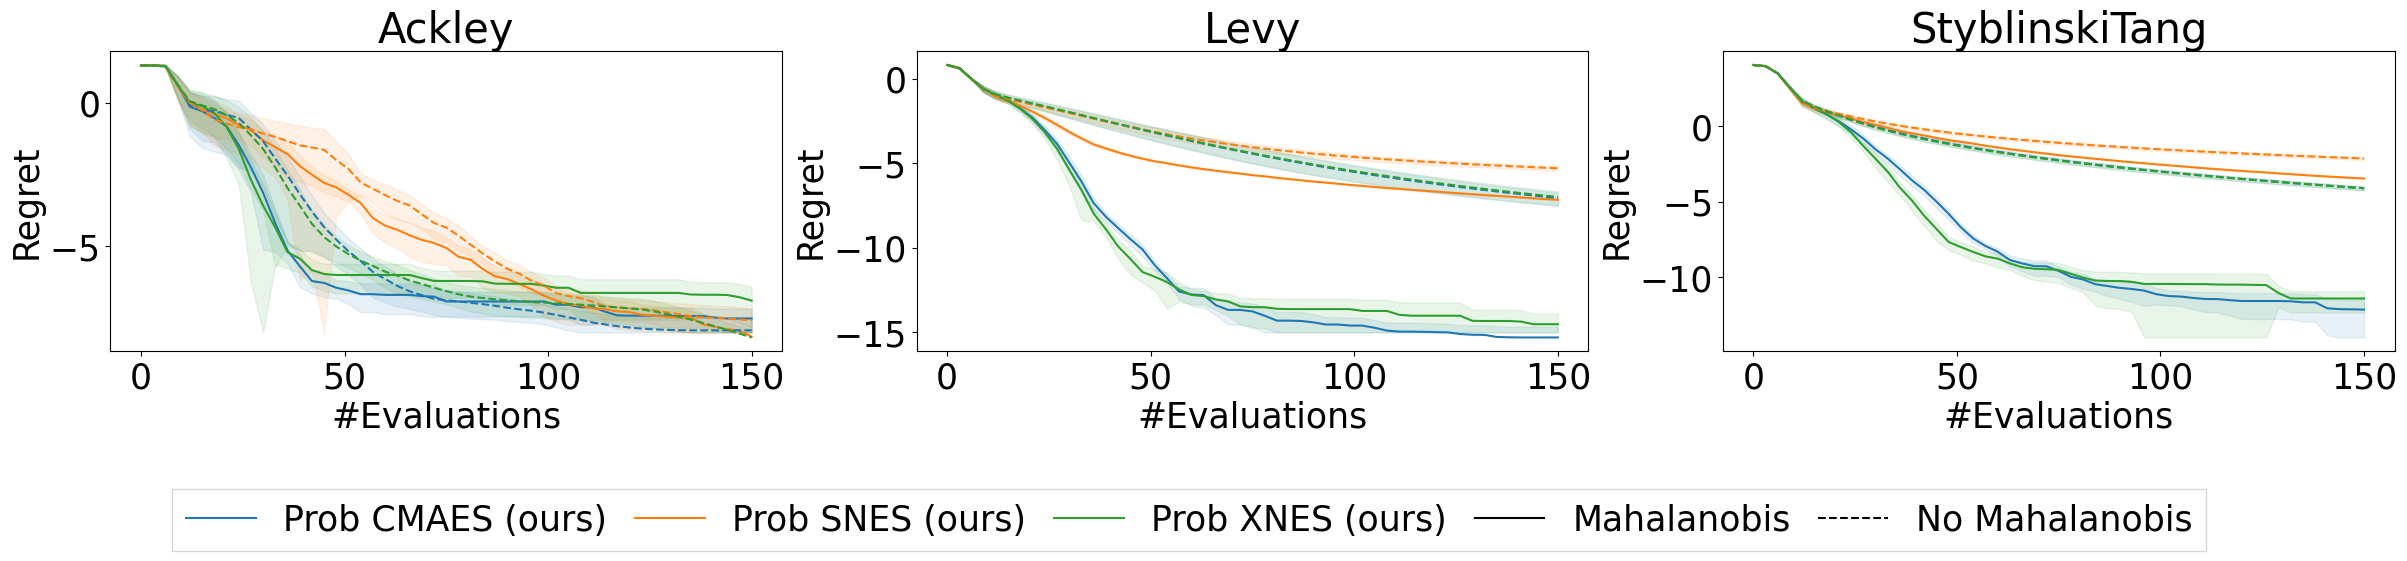

In [38]:
list_experiences = ["ackley", "Levy", "StyblinskiTang"]
list_labels = ["Ackley", "Levy", "StyblinskiTang"]
idx_letter = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)"]
matplotlib.rcParams.update({'font.size': 25})
n_rows, n_cols = 1, 3
list_amin = [-8, -15,-14]
config_name = "ablation_mahalanobis"
with open(f'config/{config_name}.yaml', 'r') as file:
        config = yaml.safe_load(file)
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 5))
for i, experience in enumerate(list_experiences):
    linestyle = "-"
    config["problem_settings"]["function"] = list_experiences[i]
    config["alg_settings"]["probES"]["mahalanobis"] = True
    config["alg_settings"]["probES"]["type"] = ["CMAES", "SNES", "XNES"]
    plot_config(axs[i], config, log_transform = True, regret = True, amin = list_amin[i], line_type=linestyle)
    config["alg_settings"]["probES"]["mahalanobis"] = False
    config["alg_settings"]["probES"]["type"] = ["CMAES", "SNES", "XNES"]
    linestyle = '--'
    plot_config(axs[i], config, log_transform = True, regret = True, amin = list_amin[i], label=False, line_type=linestyle)
    axs[i].plot([],[], c="black", ls = "-", label="Mahalanobis")
    axs[i].plot([],[], c="black", ls = "--", label="No Mahalanobis")
    axs[i].title.set_text(list_labels[i])

handles, labels = axs[0].get_legend_handles_labels()
# change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
# labels = [labels[i] for i in change_labels]
# handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=9, columnspacing=0.8)
plt.tight_layout()
#plt.legend()
#plt.show()
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.savefig("ablation_mahalanobis.pdf", bbox_inches='tight')

In [31]:
config

{'problem_name': 'test_function',
 'save_dir': './logs/ablation/mahalanobis',
 'seed': 0,
 'verbose_synthesis': 0,
 'gpu': 0,
 'overwrite': True,
 'exp_settings': {'n_exp': 10, 'n_iter': 50},
 'alg_settings': {'algorithm': 'ES',
  'verbose': 10,
  'batch_size': 3,
  'evaluation': 'mean',
  'piqEI': {'beta': 1.0,
   'mean_prior': -1.0,
   'std_prior': 1.0,
   'num_restarts': 10,
   'mc_samples': 256,
   'raw_samples': 512,
   'batch_acq': 5},
  'qEI': {'num_restarts': 10,
   'mc_samples': 256,
   'raw_samples': 512,
   'batch_acq': 5},
  'probES': {'mean_prior': -1.0,
   'std_prior': 1.0,
   'candidates_vr': 1000,
   'type': 'CMAES',
   'lr': 1.0,
   'policy': 'constant',
   'aqc_type': 'random',
   'gradient': 'expected',
   'c1': 0.0001,
   'c2': 0.9,
   't_min': 0.5,
   't_max': 2,
   'budget': 30,
   'mahalanobis': False,
   'num_restarts': 10,
   'mc_samples': 256,
   'raw_samples': 512,
   'batch_acq': 5},
  'ES': {'std_prior': 1.0, 'mean_prior': -1.0, 'type': 'CMAES'},
  'random'

# Batch Size

/tmp/ipykernel_60758/1052292277.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path, map_location="cpu")
/tmp/ipykernel_60758/1052292277.py:6: Fu

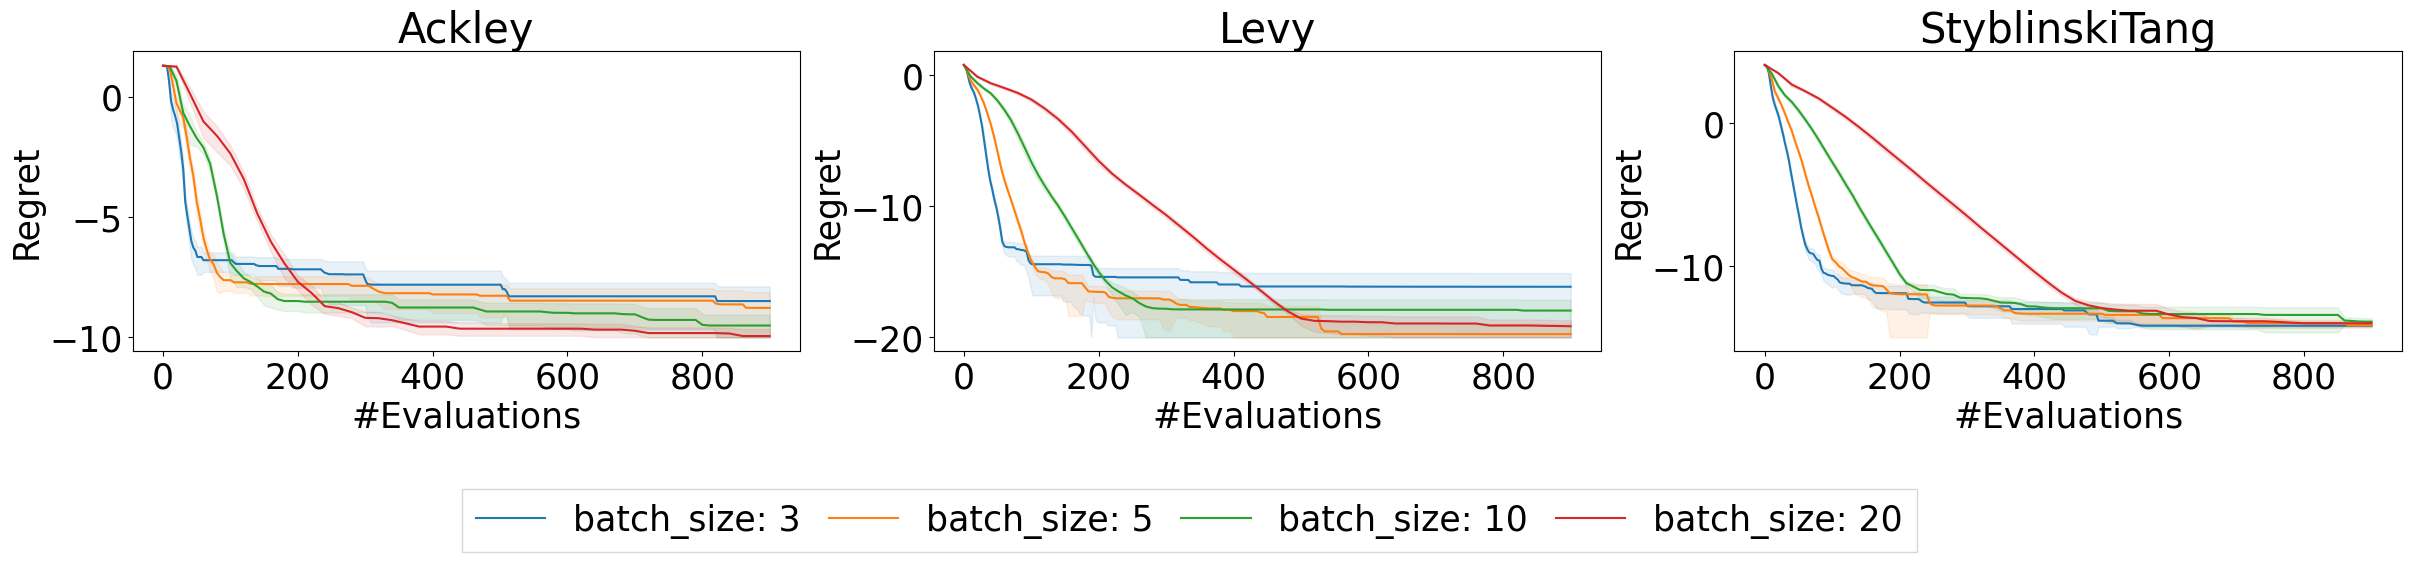

In [33]:
list_experiences = ["ackley", "Levy", "StyblinskiTang"]
list_labels = ["Ackley", "Levy", "StyblinskiTang"]
plt.rcParams['text.usetex'] = False

idx_letter = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)"]
matplotlib.rcParams.update({'font.size': 25})
n_rows, n_cols = 1, 3
list_amin = [-10, -20,-15]
config_name = "ablation_batch"
with open(f'config/{config_name}.yaml', 'r') as file:
        config = yaml.safe_load(file)
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 5))
for i, experience in enumerate(list_experiences):
    linestyle = "-"
    config["problem_settings"]["function"] = list_experiences[i]
    config["alg_settings"]["algorithm"] = "probES"
    config["alg_settings"]["batch_size"] = [3, 5, 10, 20]
    plot_config(axs[i], config, log_transform = True, regret = True, amin = list_amin[i], line_type=linestyle, ablation="batch_size")
    # config["alg_settings"]["algorithm"] = "ES"
    # config["alg_settings"]["batch_size"] = [3, 5, 20]
    # linestyle = '--'
    # plot_config(axs[i], config, log_transform = True, regret = True, amin = list_amin[i], line_type=linestyle, label=False)
    # axs[i].plot([],[], c="black", ls = "-", label="Prob CMAES")
    # axs[i].plot([],[], c="black", ls = "--", label="CMAES")
    axs[i].title.set_text(list_labels[i])

handles, labels = axs[0].get_legend_handles_labels()
# change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
# labels = [labels[i] for i in change_labels]
# handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=9, columnspacing=0.8)
plt.tight_layout()
#plt.legend()
#plt.show()
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.savefig("ablation_batch.pdf", bbox_inches='tight')

# Acq

/tmp/ipykernel_60758/4048760553.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path, map_location="cpu")
/tmp/ipykernel_60758/4048760553.py:6: Fu

['type-XNES_policy-constant_gradient-expected_', '-none_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-3_evaluation-mean']
['type-XNES_policy-constant_gradient-expected_', '-random_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-3_evaluation-mean']
['type-XNES_policy-constant_gradient-expected_', '-optimized_bound_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-3_evaluation-mean']
['type-XNES_policy-constant_gradient-expected_', '-optimized_mahalanobis_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-3_evaluation-mean']
['type-XNES_policy-constant_gradient-expected_', '-none_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-3_evaluation-mean']
['type-XNES_policy-constant_gradient-expected_', '-random_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-3_evaluation-mean']
['type-XNES_policy-constant_gradient-expected_', '-optimized_bound_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_b

/tmp/ipykernel_60758/4048760553.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path, map_location="cpu")
/tmp/ipykernel_60758/4048760553.py:6: Fu

['type-XNES_policy-constant_gradient-expected_', '-optimized_mahalanobis_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-3_evaluation-mean']
['type-XNES_policy-constant_gradient-expected_', '-none_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-3_evaluation-mean']
['type-XNES_policy-constant_gradient-expected_', '-random_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-3_evaluation-mean']
['type-XNES_policy-constant_gradient-expected_', '-optimized_bound_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-3_evaluation-mean']
['type-XNES_policy-constant_gradient-expected_', '-optimized_mahalanobis_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-3_evaluation-mean']


/tmp/ipykernel_60758/4059417708.py:40: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("ablation_acq.pdf", bbox_inches='tight')
/tmp/ipykernel_60758/4059417708.py:40: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("ablation_acq.pdf", bbox_inches='tight')
/tmp/ipykernel_60758/4059417708.py:40: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("ablation_acq.pdf", bbox_inches='tight')
/home/pierre/miniconda3/envs/semisupervised_v2/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" whi

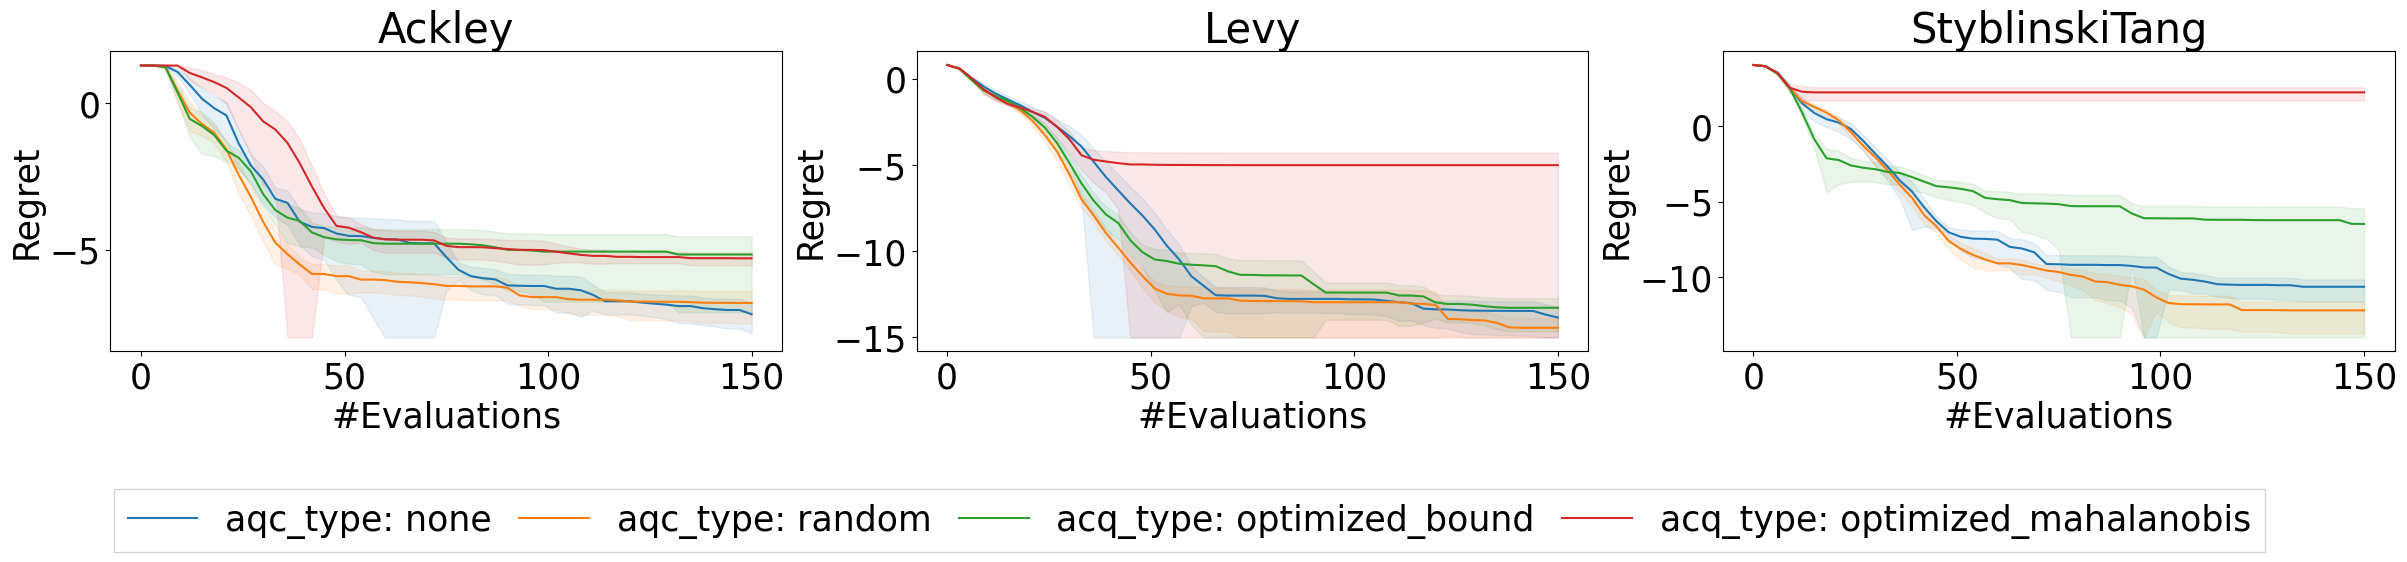

In [6]:
list_experiences = ["ackley", "Levy", "StyblinskiTang"]
list_labels = ["Ackley", "Levy", "StyblinskiTang"]

idx_letter = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)"]
matplotlib.rcParams.update({'font.size': 25})
n_rows, n_cols = 1, 3
list_amin = [-8, -15,-14]
config_name = "ablation_acq"
with open(f'config/{config_name}.yaml', 'r') as file:
        config = yaml.safe_load(file)
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 5))
for i, experience in enumerate(list_experiences):
    linestyle = "-"
    config["problem_settings"]["function"] = list_experiences[i]
    config["alg_settings"]["algorithm"] = "probES"
    config["alg_settings"]["probES"]["aqc_type"] = ["none", "random", "optimized_bound", "optimized_mahalanobis"] 
    plot_config(axs[i], config, log_transform = True, regret = True, amin = list_amin[i], line_type=linestyle, ablation="aqc_type")
    # config["alg_settings"]["algorithm"] = "ES"
    # config["alg_settings"]["batch_size"] = [3, 5, 20]
    # linestyle = '--'
    # plot_config(axs[i], config, log_transform = True, regret = True, amin = list_amin[i], line_type=linestyle, label=False)
    # axs[i].plot([],[], c="black", ls = "-", label="Prob CMAES")
    # axs[i].plot([],[], c="black", ls = "--", label="CMAES")
    axs[i].title.set_text(list_labels[i])

handles, labels = axs[0].get_legend_handles_labels()
# change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
# labels = [labels[i] for i in change_labels]
# handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=9, columnspacing=0.8)
plt.tight_layout()
#plt.legend()
#plt.show()
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.savefig("ablation_acq.pdf", bbox_inches='tight')

# Dim

/tmp/ipykernel_60758/1052292277.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path, map_location="cpu")
/tmp/ipykernel_60758/1052292277.py:6: Fu

['.', 'logs', 'ablation', 'dim', 'ackley_noise_std-0.0_dim-2_initial_bounds-10.0', 'probES', 'type-CMAES_policy-constant_gradient-expected_aqc_typef-random_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-5_evaluation-mean']
['.', 'logs', 'ablation', 'dim', 'ackley_noise_std-0.0_dim-5_initial_bounds-10.0', 'probES', 'type-CMAES_policy-constant_gradient-expected_aqc_typef-random_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-5_evaluation-mean']
['.', 'logs', 'ablation', 'dim', 'ackley_noise_std-0.0_dim-10_initial_bounds-10.0', 'probES', 'type-CMAES_policy-constant_gradient-expected_aqc_typef-random_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-5_evaluation-mean']
['.', 'logs', 'ablation', 'dim', 'ackley_noise_std-0.0_dim-20_initial_bounds-10.0', 'probES', 'type-CMAES_policy-constant_gradient-expected_aqc_typef-random_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-5_evaluation-mean']


/tmp/ipykernel_60758/1052292277.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path, map_location="cpu")
/tmp/ipykernel_60758/1052292277.py:6: Fu

['.', 'logs', 'ablation', 'dim', 'Levy_noise_std-0.0_dim-2_initial_bounds-10.0', 'probES', 'type-CMAES_policy-constant_gradient-expected_aqc_typef-random_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-5_evaluation-mean']
['.', 'logs', 'ablation', 'dim', 'Levy_noise_std-0.0_dim-5_initial_bounds-10.0', 'probES', 'type-CMAES_policy-constant_gradient-expected_aqc_typef-random_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-5_evaluation-mean']
['.', 'logs', 'ablation', 'dim', 'Levy_noise_std-0.0_dim-10_initial_bounds-10.0', 'probES', 'type-CMAES_policy-constant_gradient-expected_aqc_typef-random_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-5_evaluation-mean']
['.', 'logs', 'ablation', 'dim', 'Levy_noise_std-0.0_dim-20_initial_bounds-10.0', 'probES', 'type-CMAES_policy-constant_gradient-expected_aqc_typef-random_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-5_evaluation-mean']


/tmp/ipykernel_60758/1052292277.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path, map_location="cpu")
/tmp/ipykernel_60758/1052292277.py:6: Fu

['.', 'logs', 'ablation', 'dim', 'StyblinskiTang_noise_std-0.0_dim-2_initial_bounds-10.0', 'probES', 'type-CMAES_policy-constant_gradient-expected_aqc_typef-random_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-5_evaluation-mean']
['.', 'logs', 'ablation', 'dim', 'StyblinskiTang_noise_std-0.0_dim-5_initial_bounds-10.0', 'probES', 'type-CMAES_policy-constant_gradient-expected_aqc_typef-random_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-5_evaluation-mean']
['.', 'logs', 'ablation', 'dim', 'StyblinskiTang_noise_std-0.0_dim-10_initial_bounds-10.0', 'probES', 'type-CMAES_policy-constant_gradient-expected_aqc_typef-random_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-5_evaluation-mean']
['.', 'logs', 'ablation', 'dim', 'StyblinskiTang_noise_std-0.0_dim-20_initial_bounds-10.0', 'probES', 'type-CMAES_policy-constant_gradient-expected_aqc_typef-random_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-5_evaluation-mean']


/tmp/ipykernel_60758/1052292277.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path, map_location="cpu")
/tmp/ipykernel_60758/1052292277.py:6: Fu

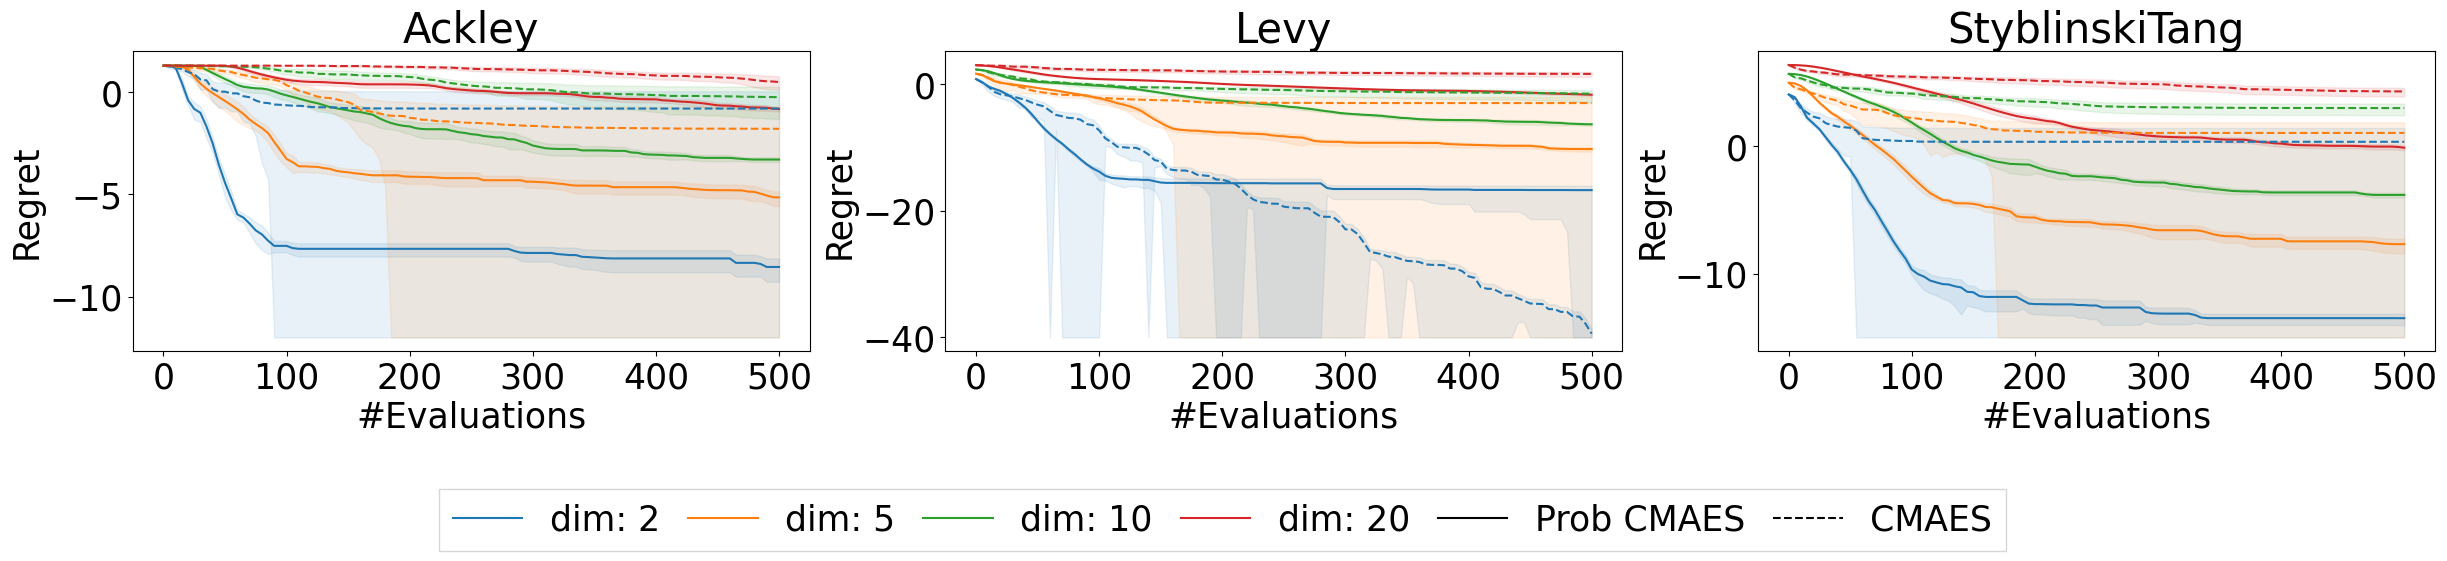

In [29]:
list_experiences = ["ackley", "Levy", "StyblinskiTang"]
list_labels = ["Ackley", "Levy", "StyblinskiTang"]

idx_letter = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)"]
matplotlib.rcParams.update({'font.size': 25})
n_rows, n_cols = 1, 3
list_amin = [-12, -40,-15]
config_name = "ablation_dim"
with open(f'config/{config_name}.yaml', 'r') as file:
        config = yaml.safe_load(file)
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 5))
for i, experience in enumerate(list_experiences):
    linestyle = "-"
    config["problem_settings"]["function"] = list_experiences[i]
    config["problem_settings"]["dim"] = [2, 5, 10, 20]
    config["alg_settings"]["algorithm"] = "probES"
    plot_config(axs[i], config, log_transform = True, regret = True, amin = list_amin[i], line_type=linestyle, ablation="dim")
    config["alg_settings"]["algorithm"] = "ES"
    config["problem_settings"]["dim"] = [2, 5, 10, 20]
    linestyle = '--'
    plot_config(axs[i], config, log_transform = True, regret = True, amin = list_amin[i], line_type=linestyle, label=False)
    axs[i].plot([],[], c="black", ls = "-", label="Prob CMAES")
    axs[i].plot([],[], c="black", ls = "--", label="CMAES")
    axs[i].title.set_text(list_labels[i])

handles, labels = axs[0].get_legend_handles_labels()
# change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
# labels = [labels[i] for i in change_labels]
# handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=9, columnspacing=0.8)
plt.tight_layout()
#plt.legend()
#plt.show()
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.savefig("ablation_dim.pdf", bbox_inches='tight')

# Prior accuracy

/tmp/ipykernel_60758/1410708537.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path, map_location="cpu")
/tmp/ipykernel_60758/1410708537.py:6: Fu

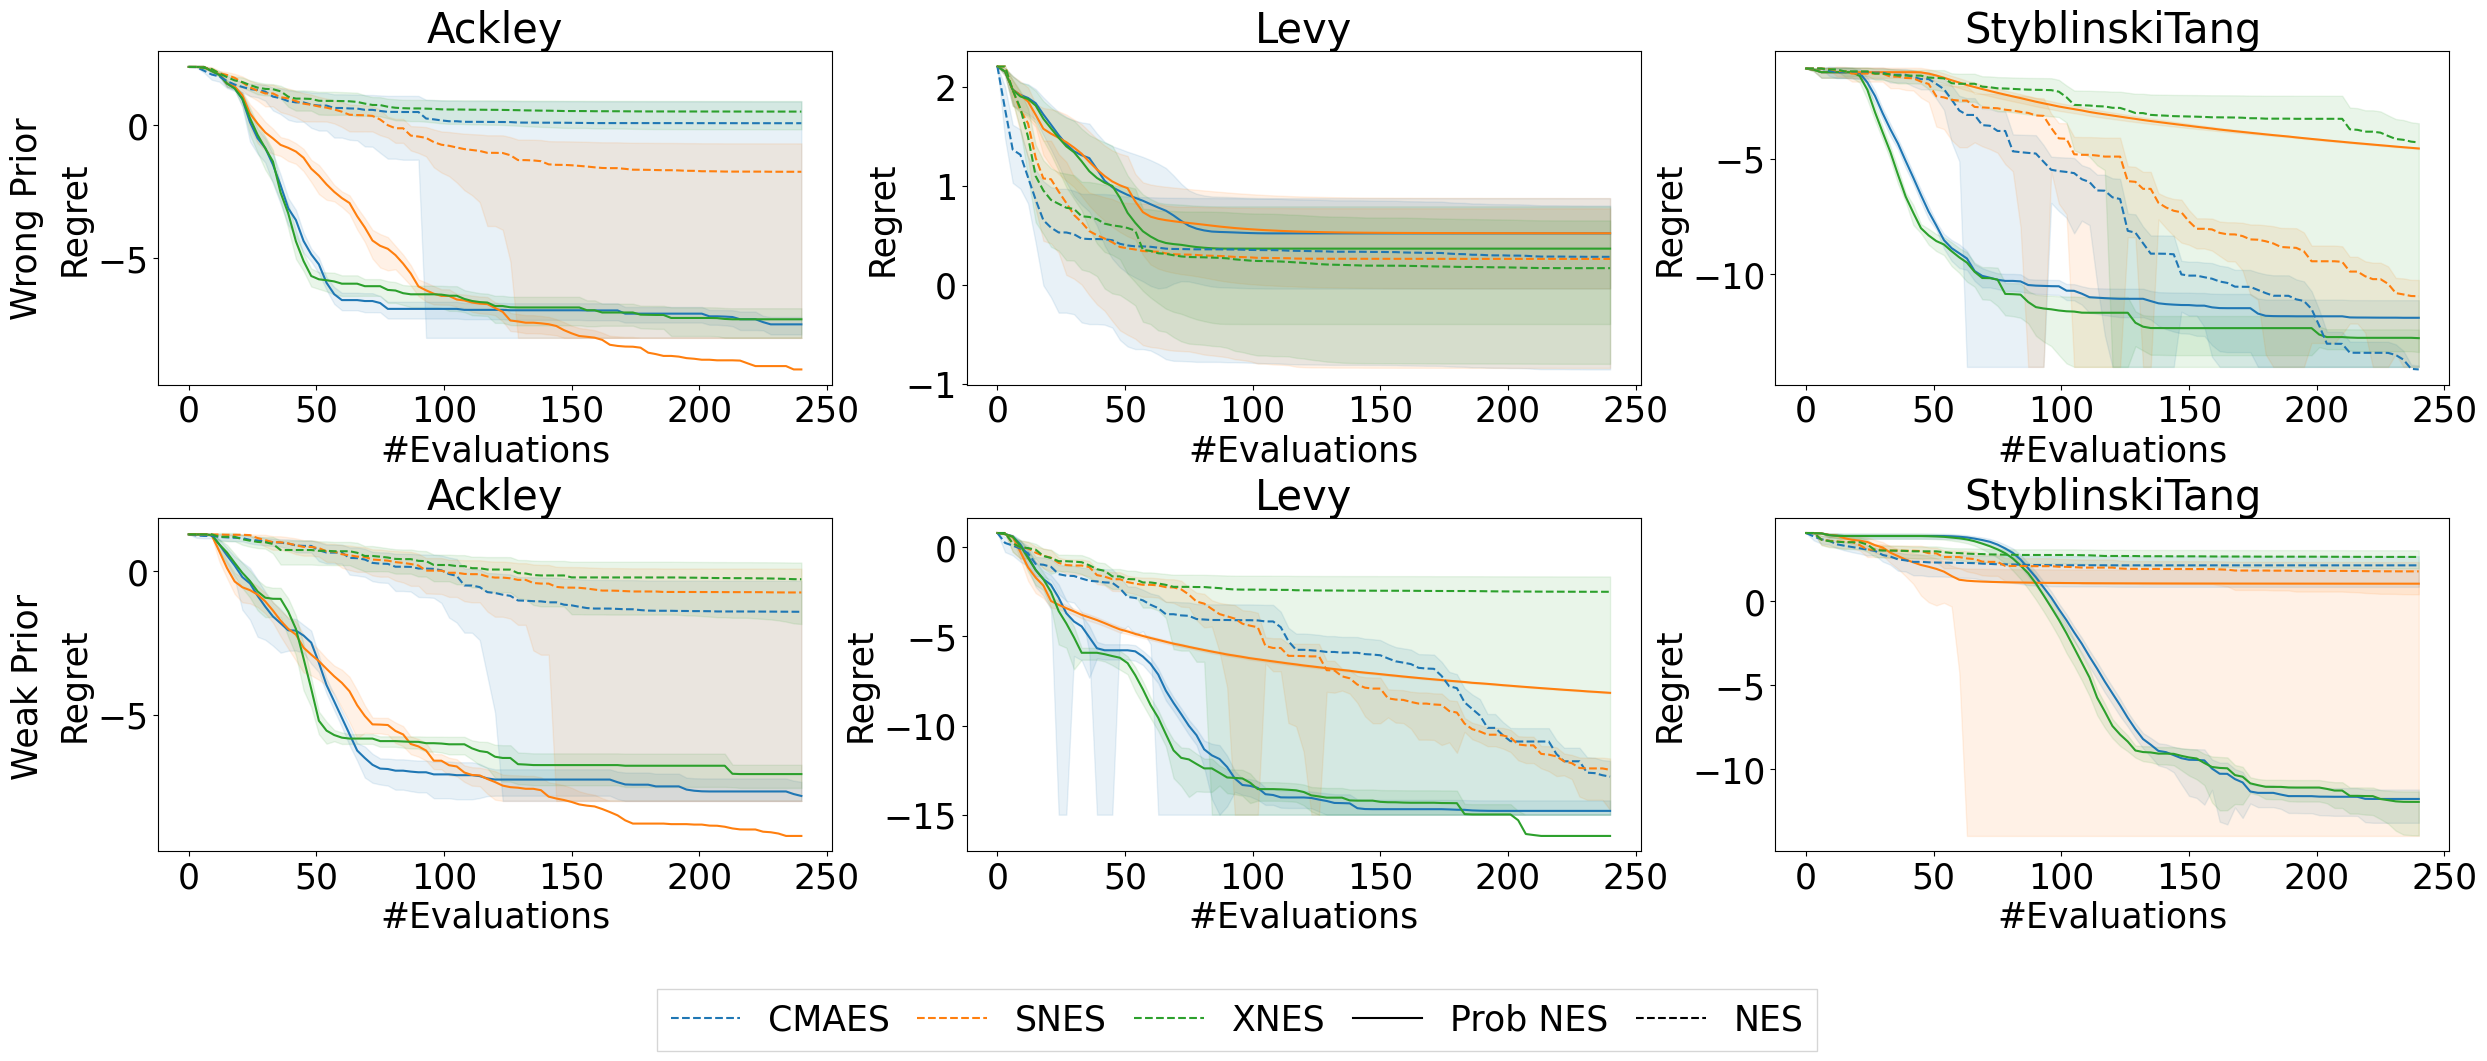

In [74]:
list_experiences = ["ackley", "Levy", "StyblinskiTang"]
list_labels = ["Ackley", "Levy", "StyblinskiTang"]
idx_letter = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)"]
matplotlib.rcParams.update({'font.size': 25})
n_rows, n_cols = 2, 3
list_amin = [-8, -15,-14]
config_name = "ablation_prior"
with open(f'config/{config_name}.yaml', 'r') as file:
        config = yaml.safe_load(file)
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 10))

for i, experience in enumerate(list_experiences):
    linestyle = "-"
    config["problem_settings"]["function"] = list_experiences[i]
    config["alg_settings"]["algorithm"] = "probES"
    config["alg_settings"]["probES"]["type"] = ["CMAES", "SNES", "XNES"]
    config["alg_settings"]["probES"]["mean_prior"] = -3.
    config["alg_settings"]["probES"]["std_prior"] = 1.
    
    plot_config(axs[0, i], config, log_transform = True, regret = True, amin = list_amin[i], label=False, line_type=linestyle)
    config["alg_settings"]["algorithm"] = "ES"
    config["alg_settings"]["ES"]["type"] = ["CMAES", "SNES", "XNES"]
    config["alg_settings"]["ES"]["mean_prior"] = -3.
    config["alg_settings"]["ES"]["std_prior"] = 1.
    linestyle = '--'
    plot_config(axs[0, i], config, log_transform = True, regret = True, amin = list_amin[i], line_type=linestyle)
    axs[0, i].plot([],[], c="black", ls = "-", label="Prob NES")
    axs[0, i].plot([],[], c="black", ls = "--", label="NES")
    axs[0, i].title.set_text(list_labels[i])

for i, experience in enumerate(list_experiences):
    linestyle = "-"
    config["problem_settings"]["function"] = list_experiences[i]
    config["alg_settings"]["algorithm"] = "probES"
    config["alg_settings"]["probES"]["type"] = ["CMAES", "SNES", "XNES"]
    config["alg_settings"]["probES"]["mean_prior"] = -1.
    config["alg_settings"]["probES"]["std_prior"] = 4.
    plot_config(axs[1, i], config, log_transform = True, regret = True, amin = list_amin[i], label=False, line_type=linestyle)
    config["alg_settings"]["algorithm"] = "ES"
    config["alg_settings"]["ES"]["type"] = ["CMAES", "SNES", "XNES"]
    config["alg_settings"]["ES"]["mean_prior"] = -1.
    config["alg_settings"]["ES"]["std_prior"] = 4.
    linestyle = '--'
    plot_config(axs[1, i], config, log_transform = True, regret = True, amin = list_amin[i], label=False, line_type=linestyle)
    axs[1, i].title.set_text(list_labels[i])

axs[0, 0].text(-70., -3.5, "Wrong Prior", rotation=90, va='center')
axs[1, 0].text(-70., -4., "Weak Prior", rotation=90, va='center')
handles, labels = axs[0, 0].get_legend_handles_labels()
# change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
# labels = [labels[i] for i in change_labels]
# handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=9, columnspacing=0.8)
plt.tight_layout()
#plt.legend()
#plt.show()
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.savefig("ablation_prior.pdf", bbox_inches='tight')

# Sampled gradient

/tmp/ipykernel_60758/1533619527.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path, map_location="cpu")
/tmp/ipykernel_60758/1533619527.py:6: Fu

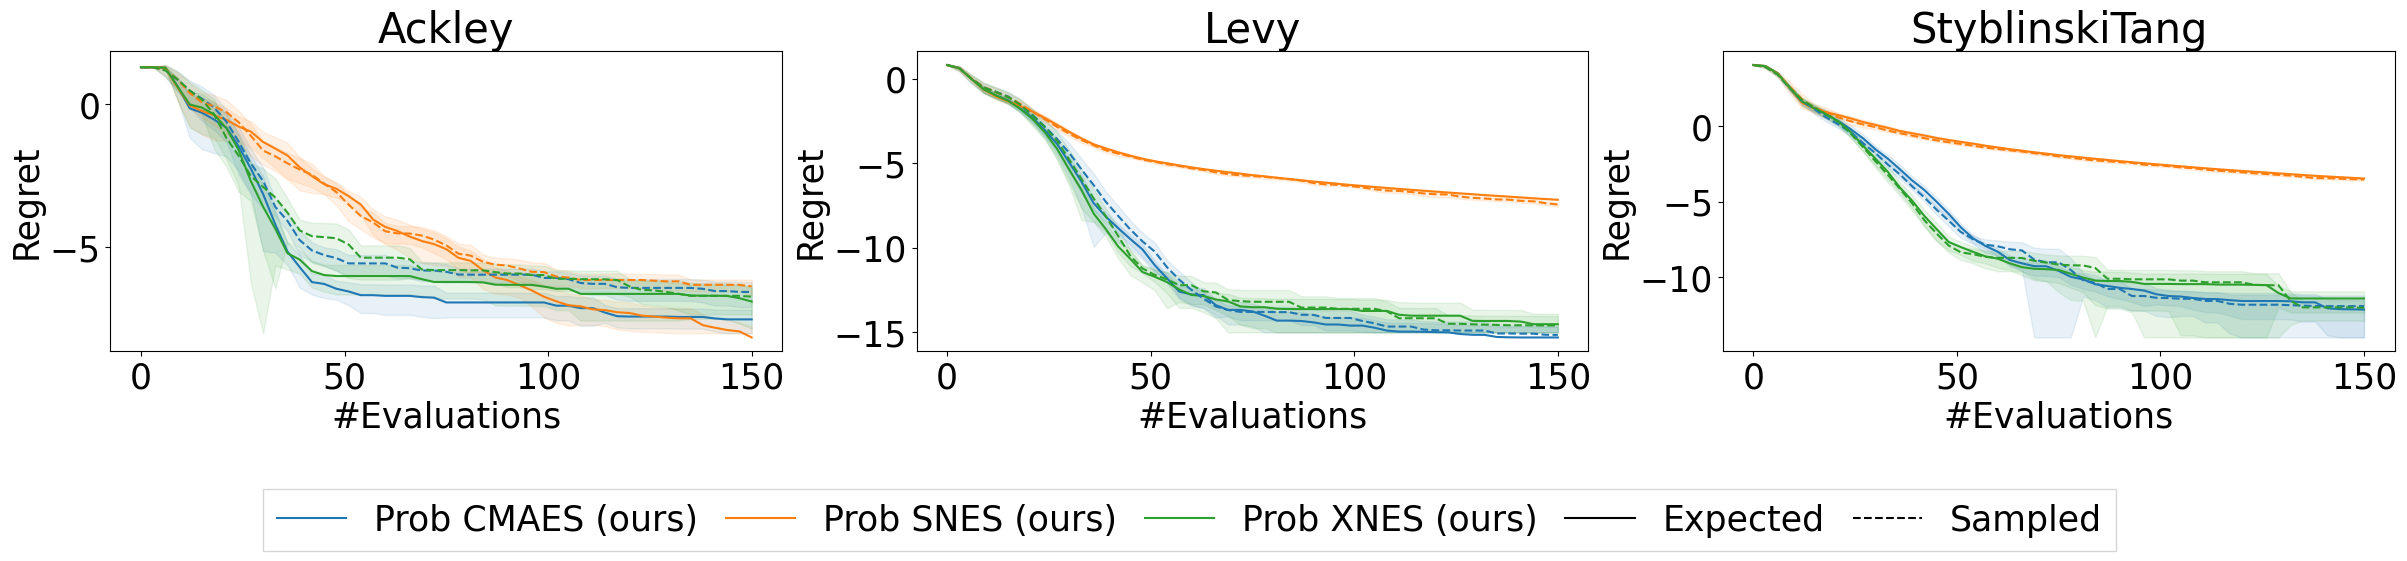

In [50]:
list_experiences = ["ackley", "Levy", "StyblinskiTang"]
list_labels = ["Ackley", "Levy", "StyblinskiTang"]
idx_letter = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)"]
matplotlib.rcParams.update({'font.size': 25})
n_rows, n_cols = 1, 3
list_amin = [-8, -15,-14]
config_name = "ablation_sampled"
with open(f'config/{config_name}.yaml', 'r') as file:
        config = yaml.safe_load(file)
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 5))
for i, experience in enumerate(list_experiences):
    linestyle = "-"
    config["problem_settings"]["function"] = list_experiences[i]
    config["alg_settings"]["probES"]["gradient"] = "expected"
    config["alg_settings"]["probES"]["type"] = ["CMAES", "SNES", "XNES"]
    plot_config(axs[i], config, log_transform = True, regret = True, amin = list_amin[i], line_type=linestyle)
    config["alg_settings"]["probES"]["gradient"] = "sampled"
    config["alg_settings"]["probES"]["type"] = ["CMAES", "SNES", "XNES"]
    linestyle = '--'
    plot_config(axs[i], config, log_transform = True, regret = True, amin = list_amin[i], label=False, line_type=linestyle)
    axs[i].plot([],[], c="black", ls = "-", label="Prob NES")
    axs[i].plot([],[], c="black", ls = "--", label="NES")
    axs[i].title.set_text(list_labels[i])

handles, labels = axs[0].get_legend_handles_labels()
# change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
# labels = [labels[i] for i in change_labels]
# handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=9, columnspacing=0.8)
plt.tight_layout()
#plt.legend()
#plt.show()
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.savefig("ablation_sampled.pdf", bbox_inches='tight')